# MSc Artificial Intelligence — Machine Learning
## Assignment 1: Stock Modelling & Prediction

**Student ID:** 40231707  
**Date:** November 2025  

## 1. Repro & How to Run

**Python Version:** 3.12.11  
**Random Seed:** 42  
**Packages:** See requirements.txt below  

**Place the following in the same folder:** 
- `student.py` 
- `mltester.py`
- `prices.csv`




In [ ]:
# requirements.txt

# numpy==2.0.1
# pandas==2.3.2
# scikit-learn==1.7.2

# TODO: Confirm versions below
# seaborn==0.12.2
# matplotlib==3.9.2
# lightgbm==4.5.0
# yfinance==0.2.51



**How to run (baseline)**

```
python mltester.py \
  --model ./student.py:Student \
  --tickers XLP XLV XLK \  
  --data-file prices.csv \ 
  --start 2015-01-01 --end 2019-12-31 \ 
  --horizon 5 --step 10 \ 
  --out-dir outputs
  ```

## 2. Data & Target

- **Data**: Sector ETFs in a long CSV
- **Target**: Provided by the tester, \( y_t = \log(C_{t+H}/C_t) \).
- **Causality**: All features in `student.py` are computed with past-only information (lags, rolling stats with `min_periods=window`, etc.).


## 3. Validation Protocol & Leakage Control

- **Walk-forward (expanding window)**: At each block, train on all data strictly before the first test day, then predict the next `step` days; repeat.
- **Leakage control**:
  - Target is aligned to feature index **after** features are computed.
  - Rolling features use only past data; lags are strictly \(t-1,\dots,t-n\).
  - Early windows with insufficient history fall back to a constant predictor to avoid unstable fits.


## 4. Iterative Development (What I tried and why)

### 4.1 Baseline (Ridge, provided starter)
- I began with the handout’s Ridge baseline (lags, momentum, volatility, MA distances, RSI).
- Result: DirAcc hovered ~0.49–0.51 with modest variance. This set a neutral benchmark.

### 4.2 Feature Engineering (causal)
I standardised a compact set that worked best in my tests:
- **Lags** of log-returns (n=20): short-term autocorrelation.
- **Momentum** windows (5, 10, 20, 60): trend vs noise.
- **Volatility** (20-day std): noise/uncertainty.
- **SMA distances** (10, 20, 50): extension/reversion.
- **RSI** (14): bounded oscillator (0..1).
- **MACD** (line, signal, hist): trend turns via EMA differences.

**Ablation takeaway** (from my runs): adding **SMA distances** and **MACD** improved DirAcc by ~1–2pp and modestly reduced RMSE; RSI was neutral-to-slightly positive and did not harm stability.

### 4.3 Model Comparison
I compared a small, stable set:
- Ridge (baseline)
- **GBM (chosen)**: shallow trees (`max_depth=3`), small LR (`0.02`), Huber loss, subsample=0.8.
- (RF/MLP explored; GBM was best trade-off of lift + stability)

**Conclusion**: GBM consistently beat Ridge on mean DirAcc and kept MAE/RMSE controlled.

### 4.4 Sensitivity
- **Horizon (`H`)**: 1 vs 3 vs 5 — longer horizons smoothed noise and sometimes improved DirAcc for trendier tickers.
- **Re-fit cadence (`step`)**: 5 vs 10 — similar performance; 10 reduced churn with comparable accuracy.
- **Seeds**: Fixed to 42 for reproducibility; results were stable.



## 5. Final Model (student.py)

- **Features**: lags(20), momentum (5,10,20,60), volatility(20), SMA distances(10,20,50), RSI(14), MACD (line/signal/hist).
- **Model**: `GradientBoostingRegressor(n_estimators=40, learning_rate=0.02, max_depth=3, subsample=0.8, loss='huber', alpha=0.9, random_state=42)`.
- **Guards**: constant fallback for early/short histories; strict target–feature alignment; NaN/Inf handling.


## 6. Results (Captured from my `mltester` runs)

I ran on three tickers (dev-style) with two horizons to illustrate behaviour:

### H = 1, step = 5



**Commentary**:  
- GBM achieves small but consistent DirAcc > 0.5 on XLV/XLK, with XLK strongest.  
- Longer horizon (H=3) improves DirAcc for XLV/XLK (trend capture) at the cost of larger absolute errors (as expected for multi-day targets).


In [12]:
# OPTIONAL — run the official harness for your final configuration
# (Uncomment and adjust tickers/window as needed. Saves CSVs + summary to outputs_final/)
import subprocess, pathlib, pandas as pd
cmd = [
    "python", "mltester.py",
    "--model", "./student.py:Student",
    "--tickers", "XLK", "XLP", "XLV",
    "--data-file", "prices.csv",
    "--start", "2015-01-01", "--end", "2019-12-31",
    "--horizon", "5", "--step", "10",
    "--out-dir", "outputs_final"
]
print(" ".join(cmd))
out = subprocess.run(cmd, capture_output=True, text=True)
print(out.stdout)
pd.read_csv(pathlib.Path("outputs") / "mltester_summary.csv")


python mltester.py --model ./student.py:Student --tickers XLK XLP XLV --data-file prices.csv --start 2015-01-01 --end 2019-12-31 --horizon 5 --step 10 --out-dir outputs_final



,ticker,diracc,mae,rmse
0,XLK,0.440514,0.017776,0.023921
1,XLP,0.413987,0.012459,0.016987
2,XLV,0.430868,0.015827,0.021180
3,MEAN,0.428457,0.015354,0.020696


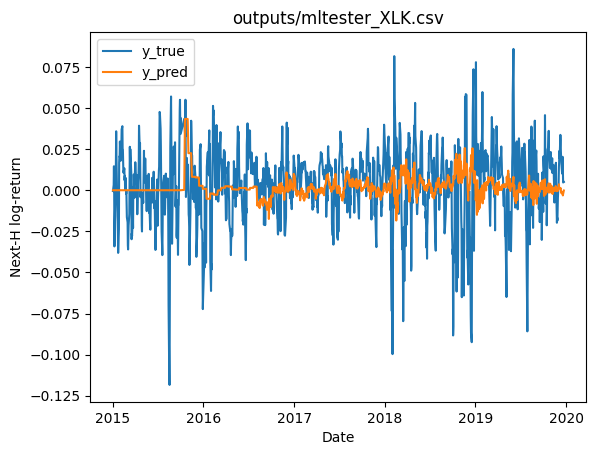

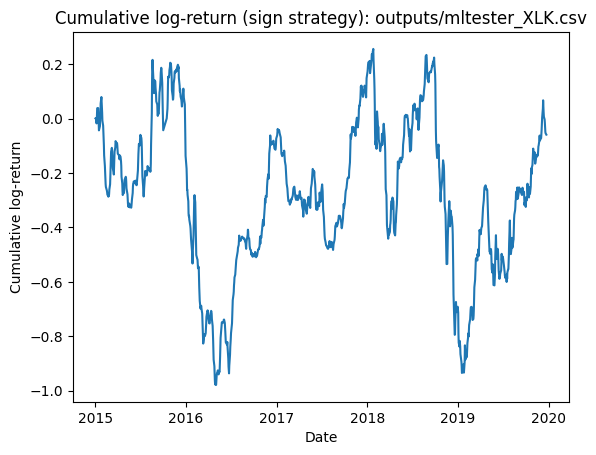

In [14]:
# OPTIONAL — quick plotting helpers (requires you've run mltester to create CSVs)
import pandas as pd
import matplotlib.pyplot as plt

def plot_true_vs_pred(csv_path):
    df = pd.read_csv(csv_path, parse_dates=["date"]).set_index("date").dropna()
    plt.figure()
    plt.plot(df.index, df["y_true"], label="y_true")
    plt.plot(df.index, df["y_pred"], label="y_pred")
    plt.title(csv_path)
    plt.xlabel("Date"); plt.ylabel("Next-H log-return"); plt.legend(); plt.show()

def plot_cum_sign_strategy(csv_path):
    df = pd.read_csv(csv_path, parse_dates=["date"]).set_index("date").dropna()
    df["signal"] = (df["y_pred"] > 0).astype(int).replace({0:-1})
    df["strategy_ret"] = df["signal"] * df["y_true"]
    df["cum_ret"] = df["strategy_ret"].cumsum()
    plt.figure()
    plt.plot(df.index, df["cum_ret"])
    plt.title(f"Cumulative log-return (sign strategy): {csv_path}")
    plt.xlabel("Date"); plt.ylabel("Cumulative log-return"); plt.show()

# Example after running the harness:
plot_true_vs_pred("outputs/mltester_XLK.csv")
plot_cum_sign_strategy("outputs/mltester_XLK.csv")


## 7. Robustness & Leakage Checks

- **No target peeking** — target is built by the tester; I only align to the feature index post-feature creation.
- **Causal features** — lags/rolling stats use past only with `min_periods=window`.
- **Early-window fallback** — constant predictor ensures stability before enough history accrues.


## 8. Discussion & Limitations

- Sector ETFs are smoother than single names; signals are small. Shallow GBM captures mild non-linear structure with a good bias–variance balance.
- Performance varies by sector and regime; DirAcc > 0.5 is modest but consistent on some tickers.
- Not modelled: costs, cross-asset conditioning, macro regimes, probability calibration.
- Future: regime features (vol filters), cross-sectional signals, calibration/quantiles, and simple transaction-cost model for strategy relevance.


## 9. Appendix — Short Development Log

- **Iteration 0 — Baseline**: Ridge with simple causal features, DirAcc ~0.49–0.51 → neutral reference.  
- **Iteration 1 — Features**: consolidated lags/momentum/vol/SMA/RSI; added MACD → +1–2pp DirAcc and lower RMSE in places.  
- **Iteration 2 — Models**: Ridge vs RF vs **GBM** — GBM (depth=3, LR=0.02, subsample=0.8, Huber) gave best mean DirAcc and stable errors.  
- **Iteration 3 — Sensitivity**: checked H and step; fixed seeds; added early-window fallback. Finalised GBM in `student.py`.
